In [1]:
import os
os.chdir('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from GLM_regression import *
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

In [44]:
# filename = "SSTindivsomata_GLM"
filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
reorganized_data, variable_list = preprocess_data(filepath)
GLM_params = fit_GLM(reorganized_data, quintile=None, regression='ridge')

reorganized_data, GLM_params= filter_neurons_by_metric(reorganized_data, GLM_params, variable_list, 
                                                       metric = 'R2',        # Options: 'R2', 'trial correlations', 'Licks', 'Reward_loc', 'Velocity', '#1', '#2', etc.
                                                       threshold = 0.8, 
                                                       scale_type = 'value', # Options: 'value', 'percentile', 'std'
                                                       keep = 'top'          # Options: 'top', 'bottom'
                                                       )

pearson R2 across all trials: 0.3024649251711122
pearson R2 (average prediction vs average activity): 0.9611549124993791


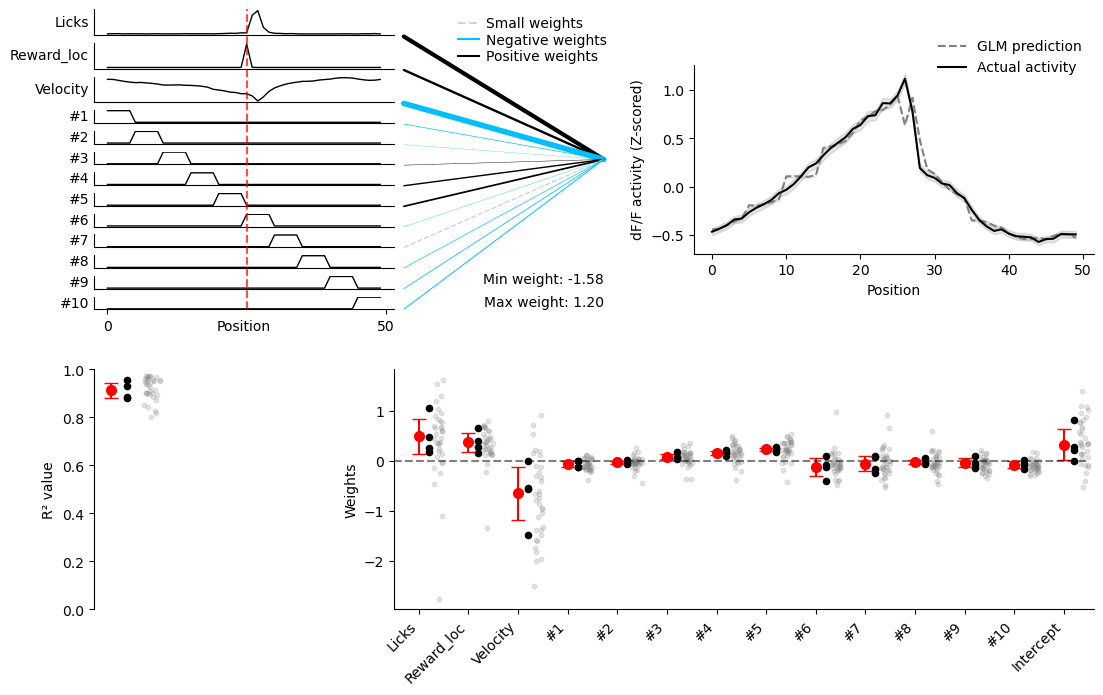

In [45]:
plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename, sort_by='R2', save=False)

Top neuron for Reward_loc, with weight: -1.3533126403815632
Best neuron: cell_5, animal_2
pearson R2 across all trials: 0.1602053143342566
pearson R2 (average prediction vs average activity): 0.8863799227734572


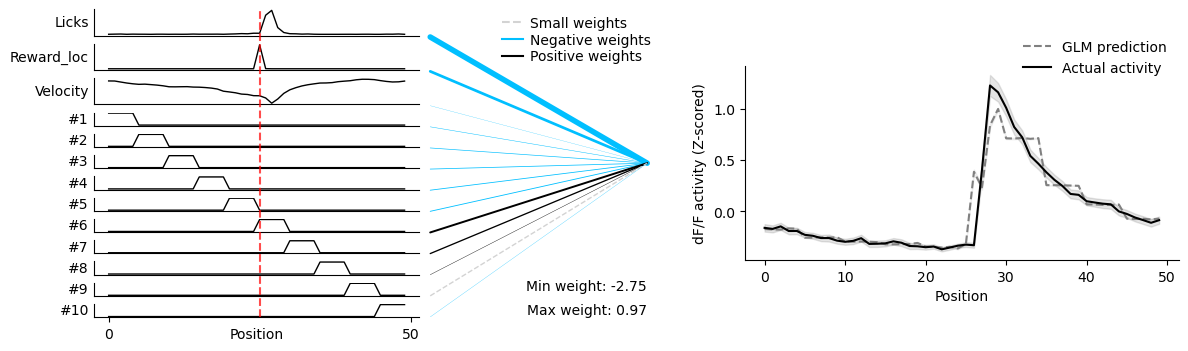

In [46]:
plot_example_neuron(reorganized_data, GLM_params, variable_list, sort_by="Reward_loc")
# plot_example_neuron(reorganized_data, GLM_params, variable_list, animal='animal_1', cell='cell_3')
# plot_GLM_summary_data(GLM_params, variable_list)

In [47]:
# datasets = ["SSTindivsomata_GLM.mat", "NDNFindivsomata_GLM.mat", "EC_GLM.mat"]

# fig = plt.figure(figsize=(18, 8))
# axes = gs.GridSpec(nrows=len(datasets), ncols=4, hspace=0.6, wspace=0.3)

# for i,filename in enumerate(datasets):
#     filepath = os.path.join("datasets", filename)
#     reorganized_data, variable_list = load_data(filepath)
#     GLM_params_start = fit_GLM(reorganized_data, quintile=1, regression='ridge')
#     GLM_params_end = fit_GLM(reorganized_data, quintile=5, regression='ridge')
#     delta_weights = calculate_delta_weights(reorganized_data, GLM_params_start, GLM_params_end)

#     ax = fig.add_subplot(axes[i, 1])
#     plot_GLM_summary_data(GLM_params_start, variable_list, ax=ax)
#     ax.set_title('First quintile')
    
#     ax = fig.add_subplot(axes[i, 2])
#     plot_GLM_summary_data(GLM_params_end, variable_list, ax=ax)
#     ax.set_title('Last quintile')

#     ax = fig.add_subplot(axes[i, 3])
#     plot_R2_distribution(GLM_params_start, GLM_params_end, ax=ax)
#     ax.set_xlim([0.5, 3.5])

#     ax = fig.add_subplot(axes[i, 0])
#     plot_delta_weights_summary(delta_weights, variable_list, model_name=filepath.split('.')[0], ax=ax)

#     if i == 0:
#         ax.scatter([],[], color='gray', label='Neurons', s=20)
#         ax.scatter([],[], color='black', label='Animal avg', s=20)
#         ax.scatter([],[], color='red', label='Overall avg', s=20)
#         ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False, handletextpad=0.5, labelspacing=0.2, borderpad=0)

# fig.savefig('figures/delta_weights_summary.png', dpi=300)

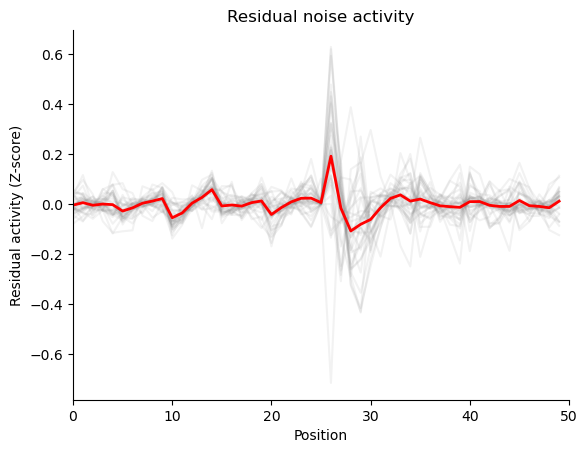

In [48]:
residual_activity, avg_residuals = compute_residual_activity(GLM_params, reorganized_data)

plt.plot(avg_residuals.T, c='gray', alpha=0.1)   
plt.plot(np.mean(avg_residuals, axis=0), c='r', lw=2) 
plt.xlim([0, 50])
plt.xlabel('Position')
plt.ylabel('Residual activity (Z-score)')
plt.title('Residual noise activity')
plt.show()

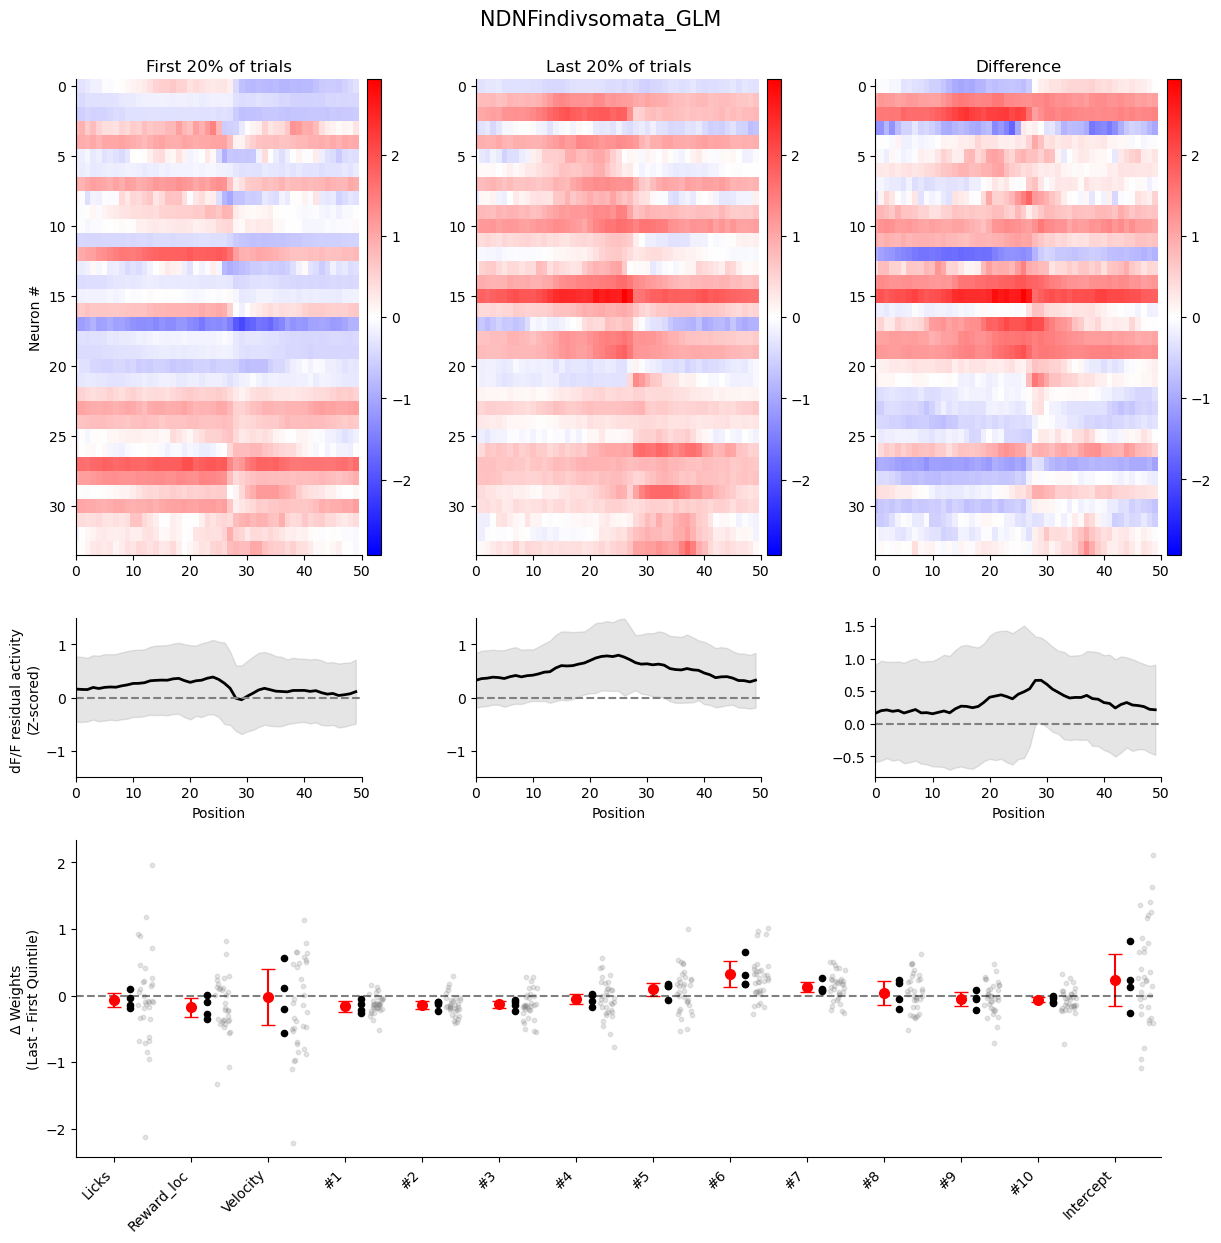

In [49]:
plot_quintile_comparison(reorganized_data, variable_list, filename, quintiles=(1,5), save=False)

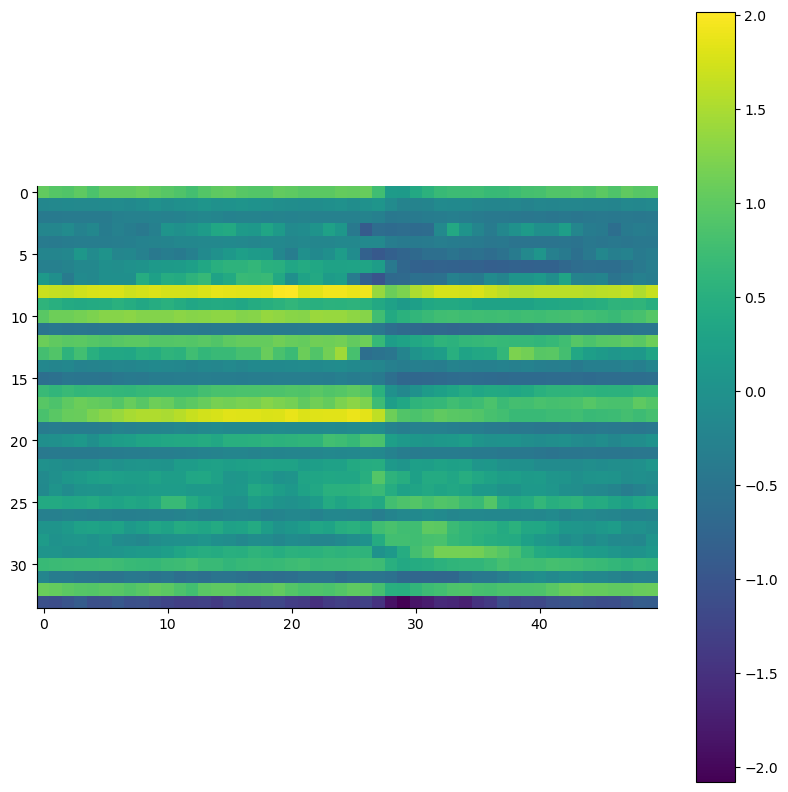

In [50]:
avg_residuals, GLM_params = compute_velocity_subtracted_residuals(reorganized_data, variable_list, quintile=1)

plt.figure(figsize=(10, 10))
sort_idx = np.argsort(np.argmax(avg_residuals, axis=1))
avg_residuals = avg_residuals[sort_idx]
plt.imshow(avg_residuals, aspect='equal', cmap='viridis', interpolation='none')
plt.colorbar()

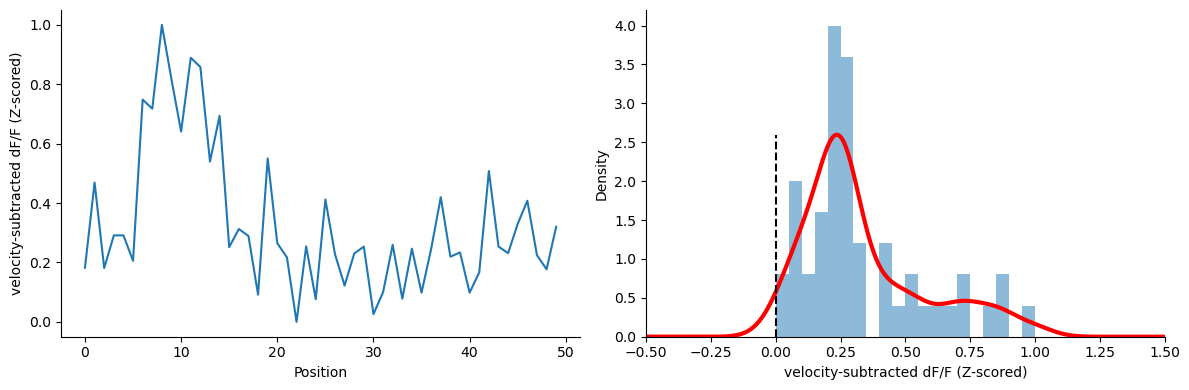

Bimodality Coefficient: 0.34
Distance between k-means centers: 0.48
Dip test p-value: 0.78, dip value: 0.04


In [23]:
avg_residuals, GLM_params = compute_velocity_subtracted_residuals(reorganized_data, variable_list, quintile=1)
cell = 50

# Renormalize residuals between 0 and 1
cell_residual = avg_residuals[cell]
cell_residual = (cell_residual - np.min(cell_residual)) / (np.max(cell_residual) - np.min(cell_residual))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(cell_residual)
ax[0].set_xlabel('Position')
ax[0].set_ylabel('velocity-subtracted dF/F (Z-scored)')

# Plot distribution of dF/F values
ax[1].hist(cell_residual, bins=20, density=True, alpha=0.5)
ax[1].set_xlabel('velocity-subtracted dF/F (Z-scored)')
ax[1].set_ylabel('Frequency')
from scipy.stats import gaussian_kde
kde = gaussian_kde(cell_residual, bw_method=0.3)
x = np.linspace(-2, 2, 1000)
y = kde(x)
ax[1].plot(x, y, c='r', lw=3)
ax[1].set_xlabel('velocity-subtracted dF/F (Z-scored)')
ax[1].set_ylabel('Density')
ax[1].set_xlim([-0.5, 1.5])
plt.vlines(0, 0, np.max(y), color='k', linestyle='--')
plt.tight_layout()
plt.show()


from scipy.stats import skew, kurtosis
import numpy as np
skewness = skew(cell_residual)
kurt = kurtosis(cell_residual, fisher=False)  # Use fisher=False to get Pearson kurtosis
n = len(cell_residual)
BC = (skewness**2 + 1) / (kurt + (3*(n-1)**2)/((n-2)*(n-3)))
print(f"Bimodality Coefficient: {BC:.2f}")

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(cell_residual.reshape(-1, 1))
labels = kmeans.labels_
centers = kmeans.cluster_centers_
variance_between_modes = np.abs(centers[0] - centers[1])
print(f"Distance between k-means centers: {variance_between_modes[0]:.2f}")

from diptest import diptest
dip_value, p_value = diptest(cell_residual)
print(f"Dip test p-value: {p_value:.2f}, dip value: {dip_value:.2f}")

In [ ]:
def compute_velocity_corrected_residuals(residual_activity, reorganized_data):
    velocity_corrected_residuals = {}
    bin_size_cm = 180/50
    for animal in reorganized_data:
        velocity_corrected_residuals[animal] = {}
        for i,neuron_data in enumerate(reorganized_data[animal]):
            neuron_data = neuron_data[:,:,~np.isnan(neuron_data).any(axis=(0,1))]
            velocity = neuron_data[:,3]
            neuron_residual = residual_activity[animal][i] / velocity * bin_size_cm
            velocity_corrected_residuals[animal][i] = neuron_residual
    return velocity_corrected_residuals

# vars_to_remove = variable_list[4:] + ['R_loc']
# filtered_GLM_params = remove_variables_from_glm(GLM_params, vars_to_remove, variable_list)
# residual_activity = compute_residual_activity(filtered_GLM_params, reorganized_data)
# residual_activity = compute_velocity_corrected_residuals(residual_activity, reorganized_data)